In [62]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random

Zachary Hill </br>
CSPB3202 </br>
github: https://github.com/zhill9142/Kaggle-Competition </br>
# Neural Network Training Using Keras 

This problem involves taking images from digital pathology scans and using them to identify metastatic cancer cells. The data provided contains some images with positive cases of cancer cells and some images that do not contain any cancer cells with the labels available in a csv.

## EDA
First the data from the csv is put into a dataframe to get the id and lables for the images.

In [3]:
train_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Looking at the info from the csv it shows the file contains 220025 samples with none of the samples being nulll.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


From the dataframe it is possible to check what fraction of samples are positive which will show what the accuracy of the model would be if it always said yes

In [5]:
total_count = train_df['label'].count()
positive_count = train_df[train_df['label']==1].label.count()
negative_count = train_df[train_df['label']==0].label.count()
print(f'There are {total_count} samples in the training set with {positive_count} being positive for cancer and {negative_count} being negative')
print(f'For a fraction of {positive_count/(positive_count + negative_count)} being positive')

There are 220025 samples in the training set with 89117 being positive for cancer and 130908 being negative
For a fraction of 0.40503124644926713 being positive


Below it can be seen how the images given look for both positive and negative images

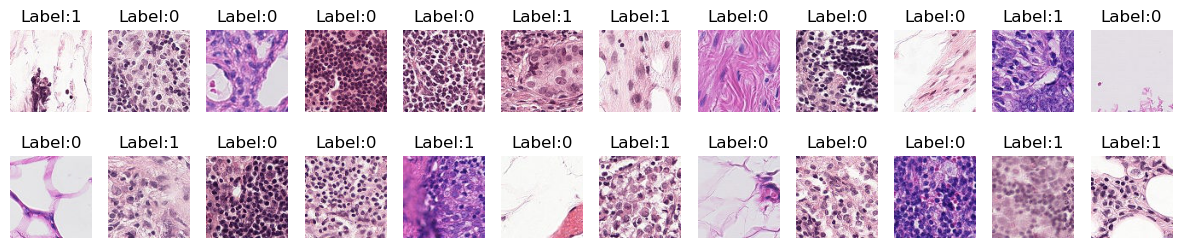

In [6]:
fig = plt.figure(figsize=(15, 3))
columns = 12
rows = 2
for i in range(1, columns*rows + 1):
    image = plt.imread("/kaggle/input/histopathologic-cancer-detection/train/" + train_df.iloc[i]["id"] + ".tif")
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('Label:' + str(train_df.iloc[i]["label"]))
    plt.imshow(image)
plt.show()

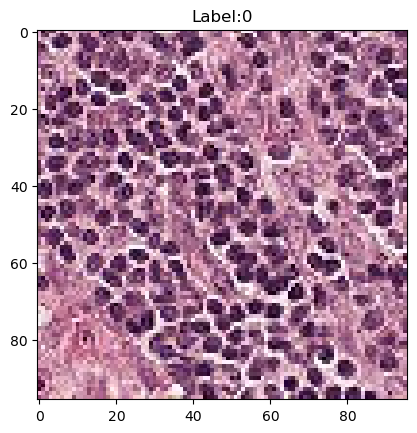

Image shape: (96, 96, 3)


In [7]:
i = random.randint(0,total_count)
rand_image = plt.imread("/kaggle/input/histopathologic-cancer-detection/train/" + train_df.iloc[i]["id"] + ".tif")
plt.imshow(rand_image)
plt.title('Label:' + str(train_df.iloc[i]["label"]))
plt.show()
print("Image shape: "+ str(rand_image.shape))

## Creating the model


In [8]:
#function for getting the training data as numpy arrays
def create_np(count, dataframe):
    label_np = dataframe['label'].to_numpy()
    image_np = np.zeros([count,96,96,3],dtype=np.uint8)
    for i in range(0, count):
        image_np[i] = (plt.imread("/kaggle/input/histopathologic-cancer-detection/train/" + dataframe.iloc[i]["id"] + ".tif"))
#     #reshape the 2d picutre with 3 channels into a 1d array
#     image_np = np.reshape(image_np, (count, 27648))
#     #convert to float32 instead of uint8
#     image_np = image_np.astype(np.float32)
#     #change rgb values to floats between 0 and 1
#     image_np /= 255
    return image_np, label_np[:count]

Using the above formula the images are formatted into numpy arrays. Only 1/100th of the images were used otherwise the model runs into RAM issues.

In [9]:
#load the data into the numpy arrays
train_images, train_labels = create_np(int(total_count*0.01), train_df)
print(train_labels.shape)
print(train_images.shape)

(2200,)
(2200, 96, 96, 3)


The taken samples are then split into training sets and validation sets

In [47]:
#split the training data into training and validation sets
training_split = 0.8
split_index = int(0.8*train_labels.shape[0])
train_label_split, val_label_split = train_labels[:split_index], train_labels[split_index:]
train_images_split, val_images_split = train_images[:split_index], train_images[split_index:]
print(train_label_split.shape, val_label_split.shape)

(1760,) (440,)


### Model 1
The first model uses the Adam optimizer with a learning rate of 0.001

In [116]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3),activation=tf.nn.relu, input_shape=(96,96,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

# We will now compile and print out a summary of our model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_21 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_19 (Flatten)        (None, 282752)            0         
                                                                 
 dense_38 (Dense)            (None, 64)                18096192  
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 18,097,281
Trainable params: 18,097,217
Non-trainable params: 64
________________________________________

In [117]:
epoch_count=[]
fit_acc=[]
val_acc=[]
for epoch in range(15):
    history = model.fit(train_images_split, train_label_split)
    loss, accuracy = model.evaluate(val_images_split, val_label_split)
    fit_loss, acc =history.history["loss"], history.history["accuracy"]
    epoch_count.append(epoch)
    fit_acc.append(acc[0])
    val_acc.append(accuracy)

14/14 [==============================] - 1s 67ms/step - loss: 1.3097 - accuracy: 0.7591


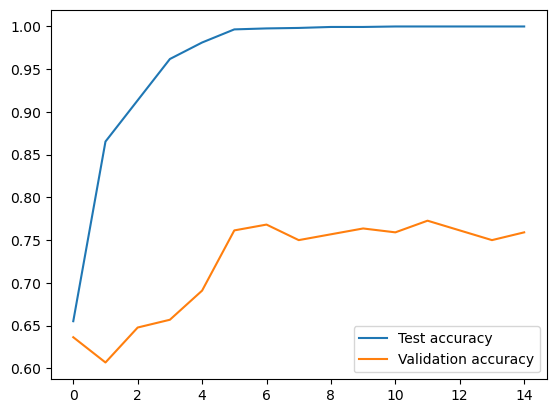

In [118]:
plt.plot(epoch_count, fit_acc, label = "Test accuracy")
plt.plot(epoch_count, val_acc, label = "Validation accuracy")
plt.legend()
plt.show()

For the first test of doing 15 epochs we can see how the test accuracy got to a really high level but the validation stayed relatively low. At around 5 epochs overfitting is seens and the validation accuracy stops improving so going above 5 is not neccessary for future models. Tuning some of the hyperparamters could help imporve the accuracy after validation. For the next model the learning rate will be improved to get a better value.
## Model 2

In [121]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3),activation=tf.nn.relu, input_shape=(96,96,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

# We will now compile and print out a summary of our model
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_23 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_21 (Flatten)        (None, 282752)            0         
                                                                 
 dense_42 (Dense)            (None, 64)                18096192  
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 18,097,281
Trainable params: 18,097,217
Non-trainable params: 64
________________________________________

In [122]:
epoch_count=[]
fit_acc=[]
val_acc=[]
for epoch in range(5):
    history = model.fit(train_images_split, train_label_split)
    loss, accuracy = model.evaluate(val_images_split, val_label_split)
    fit_loss, acc =history.history["loss"], history.history["accuracy"]
    epoch_count.append(epoch)
    fit_acc.append(acc[0])
    val_acc.append(accuracy)

14/14 [==============================] - 1s 72ms/step - loss: 4.0646 - accuracy: 0.7136


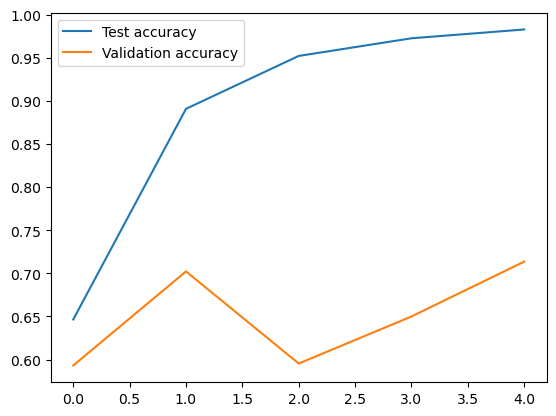

In [123]:
plt.plot(epoch_count, fit_acc, label = "Test accuracy")
plt.plot(epoch_count, val_acc, label = "Validation accuracy")
plt.legend()
plt.show()

### Tuning learning rate
Testing 0.01 first caused the accuracy of the model to drop and not rise above 0.6 so it was likely too high. </br>
At a learning rate of 0.005 the accuracy dropped all the way to 0.45 so maybe the learnign rate needs to be lower to get better values. </br>
Dropping to 0.0002 improved the accuracy slightly to 0.73 so maybe it needs to go even lower. </br>
Lastly testing with 0.00001 dropped the accuracy by a small amount to 0.69 so tuning the rate any lower probably will not help. </br>
At the end the model will be kept at 0.0002 learning rate.

### Model 3
For the third model more layers will ba added to try and see how the accuracy changes.

In [113]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3),activation=tf.nn.relu, input_shape=(96,96,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3,3),activation=tf.nn.relu, use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

# We will now compile and print out a summary of our model
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_19 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization_20 (Bat  (None, 92, 92, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                     

In [114]:
epoch_count=[]
fit_acc=[]
val_acc=[]
for epoch in range(5):
    history = model.fit(train_images_split, train_label_split)
    loss, accuracy = model.evaluate(val_images_split, val_label_split)
    fit_loss, acc =history.history["loss"], history.history["accuracy"]
    epoch_count.append(epoch)
    fit_acc.append(acc[0])
    val_acc.append(accuracy)

14/14 [==============================] - 2s 153ms/step - loss: 0.5735 - accuracy: 0.7227


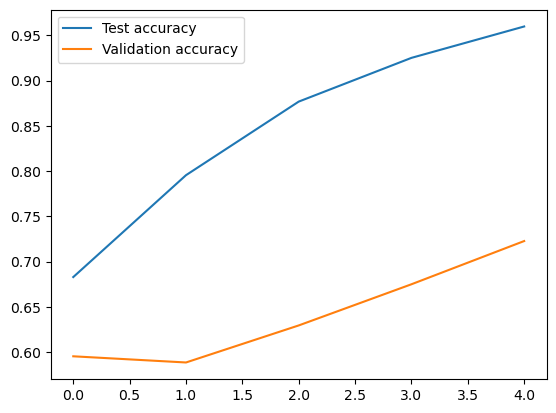

In [115]:
plt.plot(epoch_count, fit_acc, label = "Test accuracy")
plt.plot(epoch_count, val_acc, label = "Validation accuracy")
plt.legend()
plt.show()

### Chaning the layers in the model
I added another Conv2D layer before the flatten to see if it would help but even though it took longer to train the results came out as mostly the same. </br>
Adding the MaxPool2D also increased the training time but accuracy mostly stayed the same again. </br>
I am not sure where to go with adding more layers so I'll stop with that.

## Submission Process

In [91]:
#submission code from 'Complete beginner's guide [EDA, Keras, LB 0.93]'
from glob import glob
test_dir = "/kaggle/input/histopathologic-cancer-detection/test/"
test_files = glob(os.path.join(test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 10000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[5].split(".")[0])
    test_df['image'] = test_df['path'].map(plt.imread)
    K_test = np.stack(test_df["image"].values) 
    predictions = model.predict(K_test,verbose = 1) 
    test_df['label'] = predictions 
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

Indexes: 0 - 10000
313/313 [==============================] - 22s 69ms/step
Indexes: 10000 - 20000
313/313 [==============================] - 20s 65ms/step
Indexes: 20000 - 30000
313/313 [==============================] - 21s 68ms/step
Indexes: 30000 - 40000
313/313 [==============================] - 21s 67ms/step
Indexes: 40000 - 50000
313/313 [==============================] - 21s 69ms/step
Indexes: 50000 - 60000
234/234 [==============================] - 16s 68ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,3.755584e-08
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,2.335341e-19
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,5.450797e-09
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,8.451352e-01
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1.549299e-06


In [92]:
submission.to_csv("submission.csv", index = False, header = True)
submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,3.755584e-08
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,2.335341e-19
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,5.450797e-09
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,8.451352e-01
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1.549299e-06


## Conclusion
Overall I feel like I would need to work a lot more to really understand what is going on when training neural networks. I am slowly tuning the paramaters to try and get better accuracy but I do not have a good intuition yet about what should be changed to improve the accuracy more. In the future I would want to work on understanding what layers to use for a problem and how I can change them to improve the accuracy. Overall, I think it was good practice and going over some of the other submissions and creating my own helped me better understand how to do this again in the future.

## References
https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93 </br>
https://www.kaggle.com/code/akitsuyoshi/cnn-using-transfer-learning-in-keras </br>
https://keras.io/api/layers/convolution_layers/convolution2d/